In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/apple/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:13<00:00,  5.62it/s]


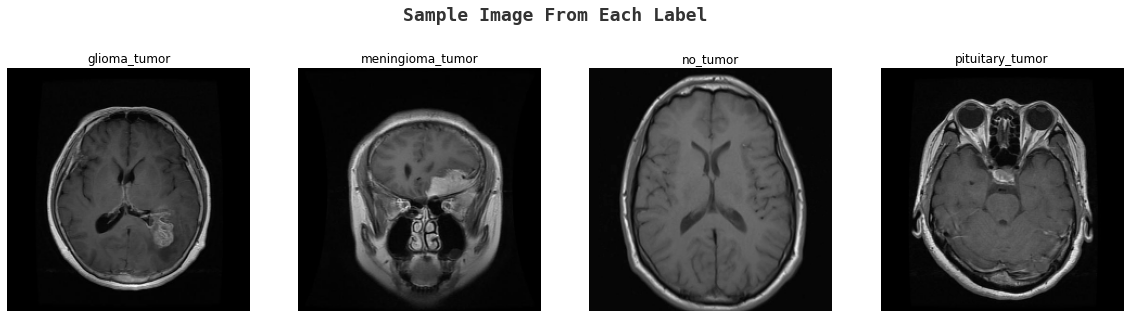

In [4]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

In [6]:
X_train.shape

(2870, 224, 224, 3)

In [7]:
X_test.shape

(394, 224, 224, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


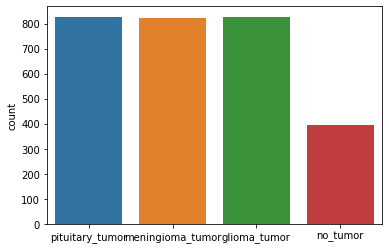

In [8]:
sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


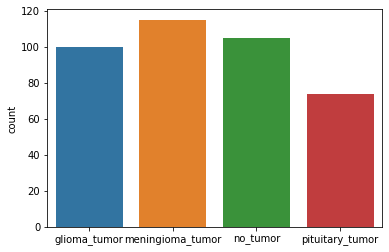

In [9]:
sns.countplot(y_test)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

In [12]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

**CNN approach**

In [16]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))


model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization()) 

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35)) 

model_cnn.add(Conv2D(64, (3, 3), padding='same')) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35)) 

model_cnn.add(Conv2D(64, (3, 3), padding='same')) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten()) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(512)) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4)) 
model_cnn.add(Activation('softmax'))

model_cnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                    

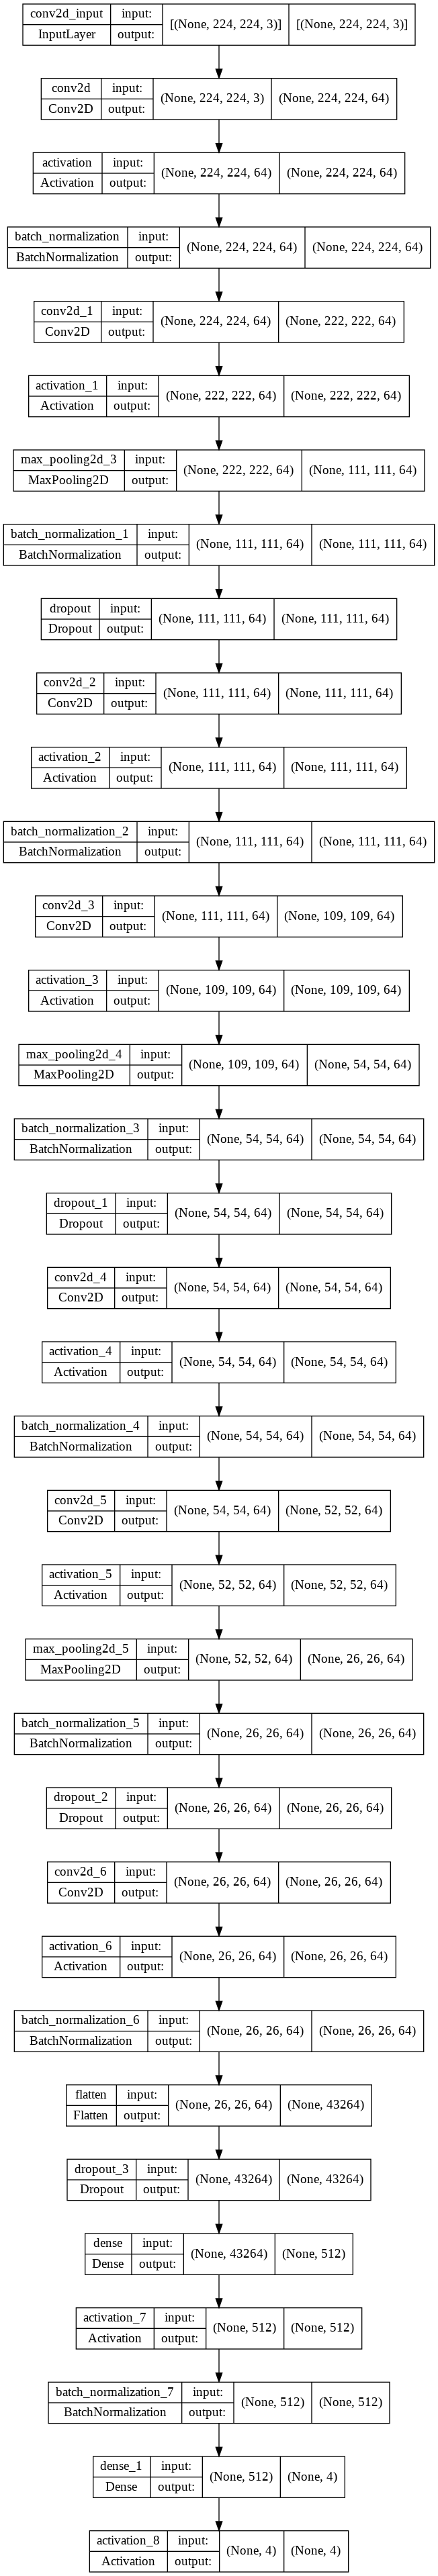

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [19]:
history = model_cnn.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 1.1102 - accuracy: 0.6661
Epoch 1: val_accuracy improved from -inf to 0.29730, saving model to effnet.h5
73/73 [==============================] - 22s 154ms/step - loss: 1.1102 - accuracy: 0.6661 - val_loss: 8.7096 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.7995
Epoch 2: val_accuracy did not improve from 0.29730
73/73 [==============================] - 9s 121ms/step - loss: 0.5300 - accuracy: 0.7995 - val_loss: 9.0108 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.4045 - accuracy: 0.8481
Epoch 3: val_accuracy did not improve from 0.29730

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 [==============================] - 9s 121ms/step - loss: 0.4045 - accuracy: 0.8481 - val_loss: 6.4857 - val_accuracy: 0.1506 - lr: 0.0010
Epoch 4/20
73/73 [=========

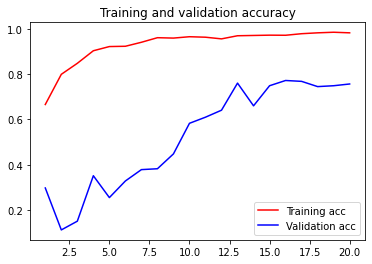

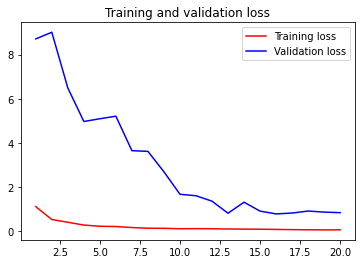

In [20]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [21]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [22]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 63.96%


**Evaluation**

In [23]:
model_cnn.evaluate(X_train, y_train)

81/81 [==============================] - 3s 39ms/step - loss: 0.4585 - accuracy: 0.8362


[0.45852386951446533, 0.8362369537353516]

In [24]:
print(classification_report(y_test_new,pred)) #0 is for glioma , 1 is for meningioma, 2 is for no tumor and 3 is for pituatary tumor

              precision    recall  f1-score   support

           0       0.62      0.05      0.09       100
           1       0.76      0.81      0.78       115
           2       0.57      0.95      0.72       105
           3       0.61      0.73      0.66        74

    accuracy                           0.64       394
   macro avg       0.64      0.64      0.56       394
weighted avg       0.65      0.64      0.57       394



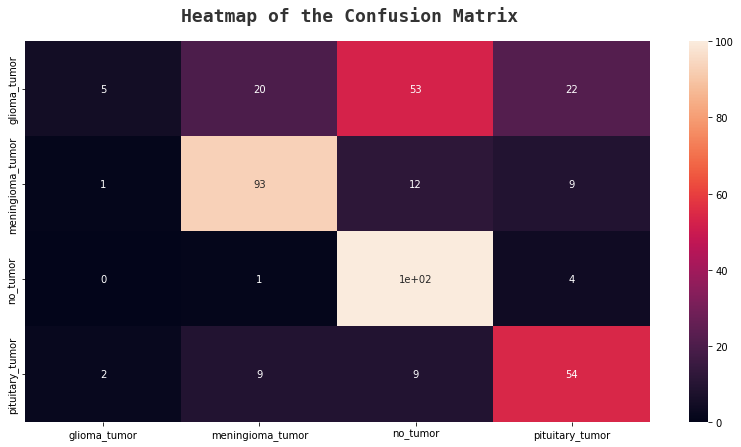

In [25]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

#Another Proposed CNN Model

In [26]:
import tensorflow
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
loss = SparseCategoricalCrossentropy()
model = Sequential()
model.add(tensorflow.keras.Input(shape=(224,224,3), name="Layer1"))
model.add(Conv2D(16, (3,3), activation="relu", name="Layer3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (6,6), activation="relu", name="Layer4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))   
model.add(Dropout(0.2))
model.add(Conv2D(32, (6,6), activation="relu", name="Layer5"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))    
model.add(Dropout(0.2))
model.add(Flatten(name="Layer6"))   
model.add(Dense(64, activation="relu", name="Layer7"))
model.add(Dense(4, activation="softmax", name="Layer8"))
model.compile(
loss=loss,
optimizer="adam",
metrics=["accuracy"],run_eagerly=True)

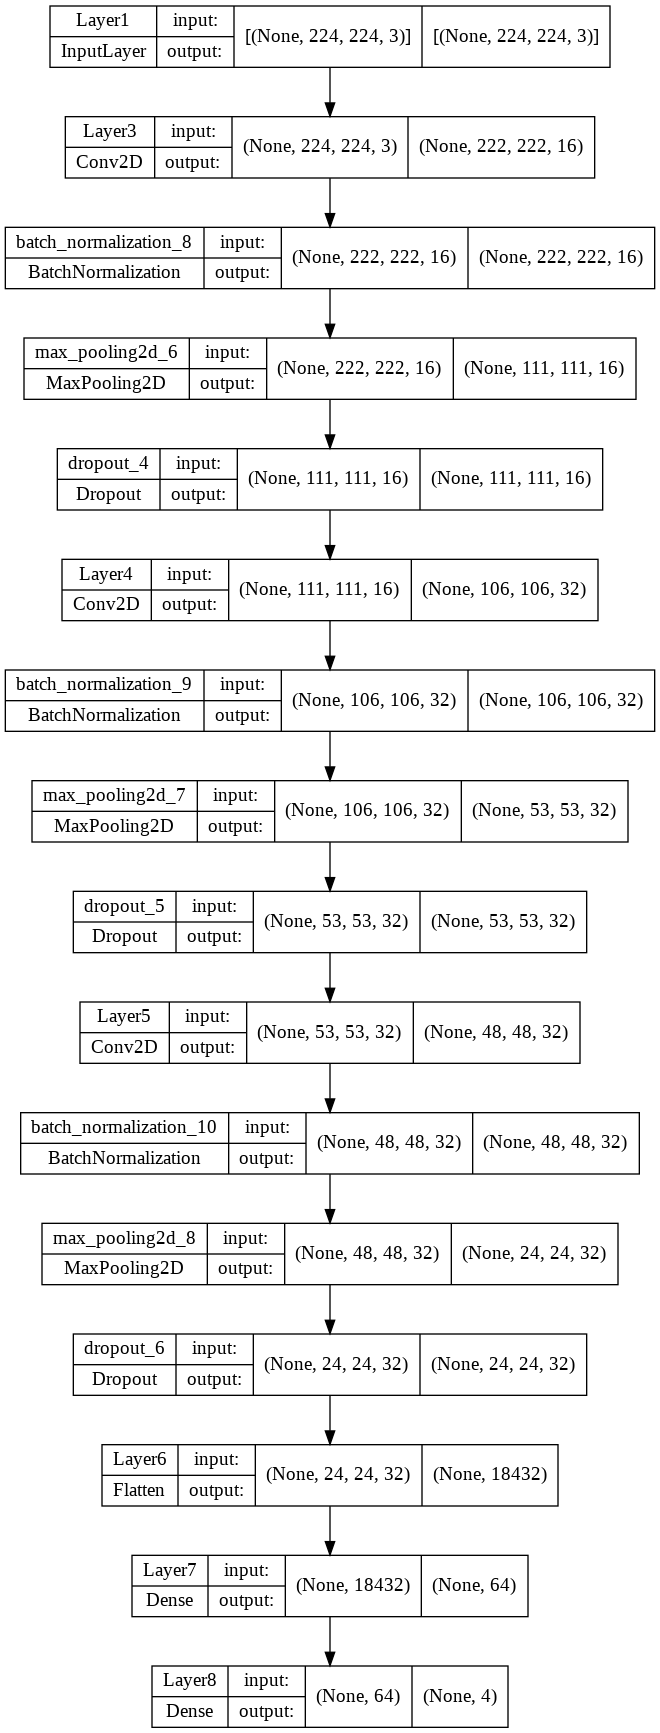

In [27]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [28]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [29]:
history = model.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 1.7094 - accuracy: 0.5843
Epoch 1: val_accuracy did not improve from 0.77220
73/73 [==============================] - 3s 36ms/step - loss: 1.7094 - accuracy: 0.5843 - val_loss: 1.4894 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 2/20
71/73 [============================>.] - ETA: 0s - loss: 0.6388 - accuracy: 0.7188
Epoch 2: val_accuracy did not improve from 0.77220
73/73 [==============================] - 2s 29ms/step - loss: 0.6343 - accuracy: 0.7212 - val_loss: 1.6753 - val_accuracy: 0.3320 - lr: 0.0010
Epoch 3/20
71/73 [============================>.] - ETA: 0s - loss: 0.4658 - accuracy: 0.8011
Epoch 3: val_accuracy did not improve from 0.77220

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 [==============================] - 2s 29ms/step - loss: 0.4683 - accuracy: 0.8003 - val_loss: 1.6524 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 4/20
71/73 [============================>.] - ETA: 0s

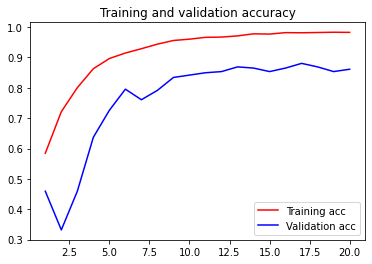

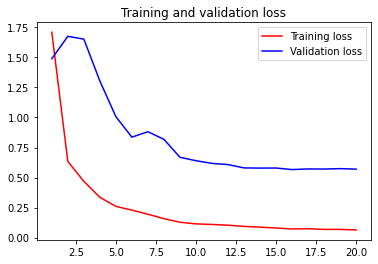

In [30]:
model.save('model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
predi = model.predict(X_test)
predi = np.argmax(predi,axis=1)
y_test_neww = np.argmax(y_test,axis=1)

In [32]:
accuracy = np.sum(predi==y_test_neww)/len(predi)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 64.72%


In [33]:
model.evaluate(X_train, y_train)

81/81 [==============================] - 1s 11ms/step - loss: 0.1264 - accuracy: 0.9675


[0.1264081597328186, 0.9674796462059021]

In [34]:
print(classification_report(y_test_neww,predi))

              precision    recall  f1-score   support

           0       0.80      0.16      0.27       100
           1       0.59      0.87      0.70       115
           2       0.64      0.93      0.76       105
           3       0.80      0.55      0.66        74

    accuracy                           0.65       394
   macro avg       0.71      0.63      0.60       394
weighted avg       0.70      0.65      0.60       394



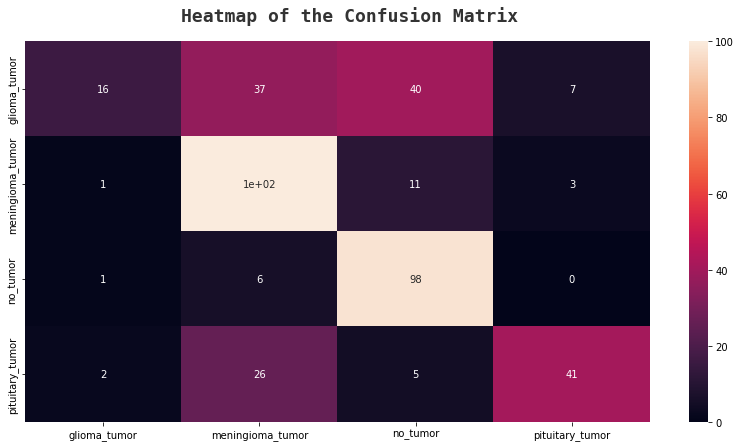

In [35]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_neww,predi),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**VGG16**




In [36]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [37]:
for layers in vgg.layers:
  layers.trainable=False

In [38]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

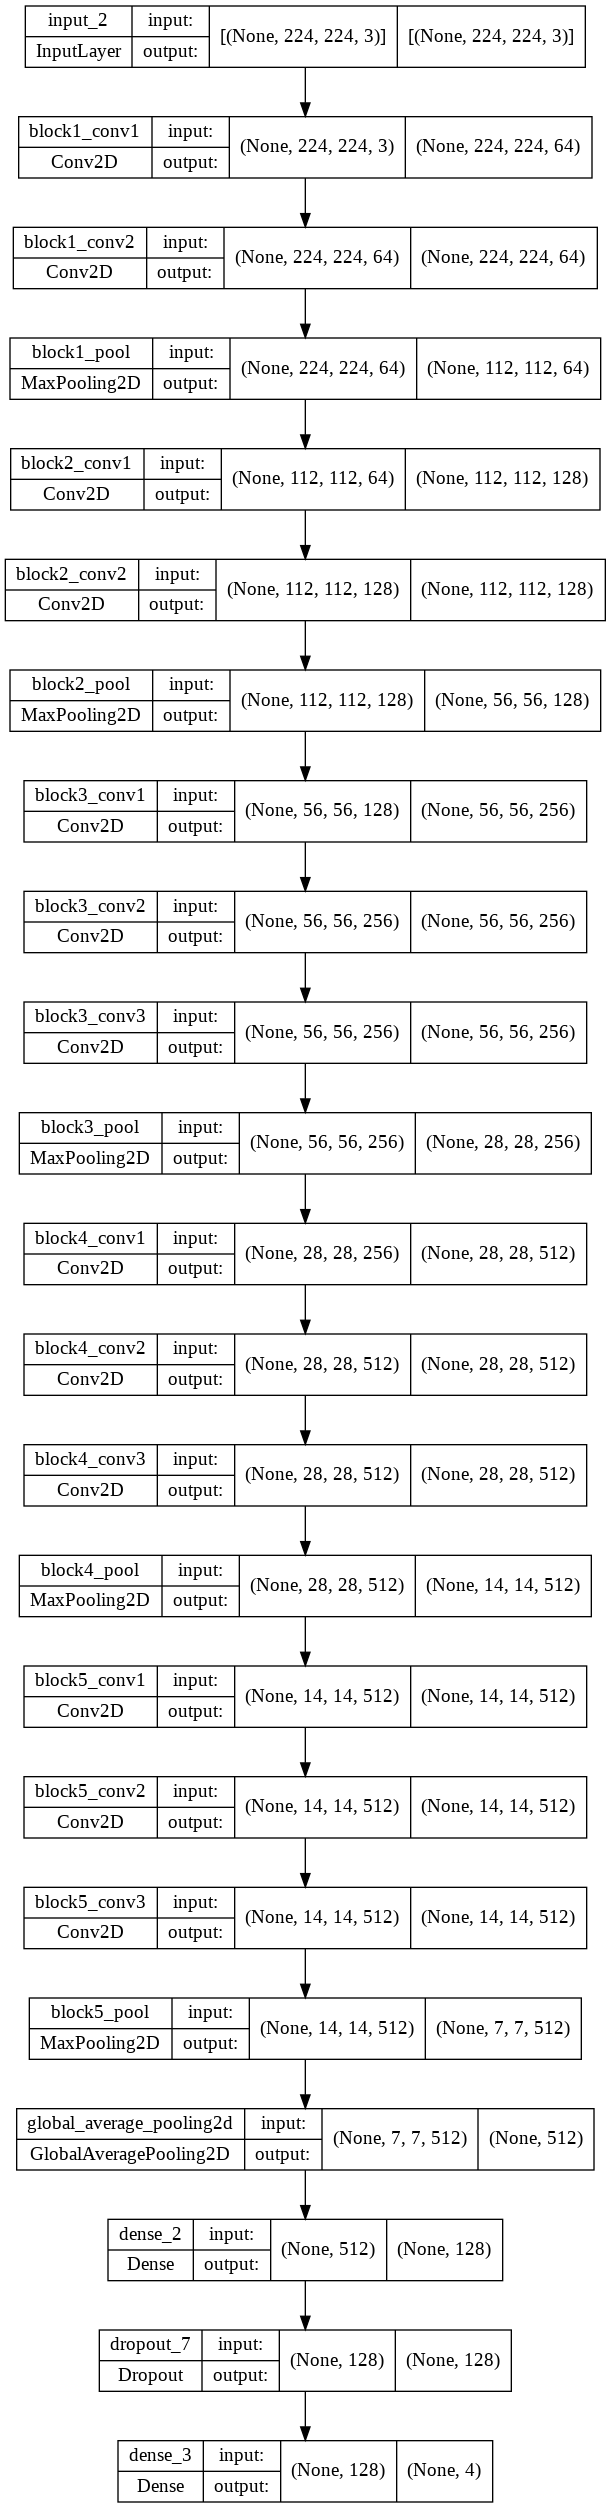

In [39]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [41]:
history = model_vgg.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.4897
Epoch 1: val_accuracy did not improve from 0.88031
73/73 [==============================] - 9s 100ms/step - loss: 1.1785 - accuracy: 0.4897 - val_loss: 0.9774 - val_accuracy: 0.7066 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.8795 - accuracy: 0.6794
Epoch 2: val_accuracy did not improve from 0.88031
73/73 [==============================] - 6s 86ms/step - loss: 0.8795 - accuracy: 0.6794 - val_loss: 0.7678 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.7226 - accuracy: 0.7423
Epoch 3: val_accuracy did not improve from 0.88031
73/73 [==============================] - 6s 87ms/step - loss: 0.7226 - accuracy: 0.7423 - val_loss: 0.6743 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7719
Epoch 4: val_accuracy did not improve fro

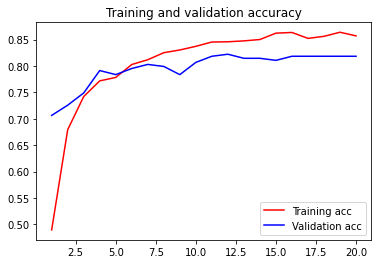

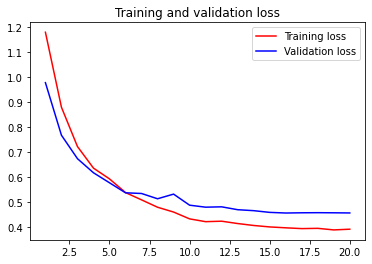

In [42]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [43]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [44]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 53.30%


**Evaluation**

In [45]:
model_vgg.evaluate(X_train, y_train)

81/81 [==============================] - 7s 85ms/step - loss: 0.3872 - accuracy: 0.8602


[0.38717687129974365, 0.8602400422096252]

In [46]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.44      0.18      0.26       100
           1       0.51      0.61      0.55       115
           2       0.49      0.68      0.57       105
           3       0.74      0.69      0.71        74

    accuracy                           0.53       394
   macro avg       0.54      0.54      0.52       394
weighted avg       0.53      0.53      0.51       394



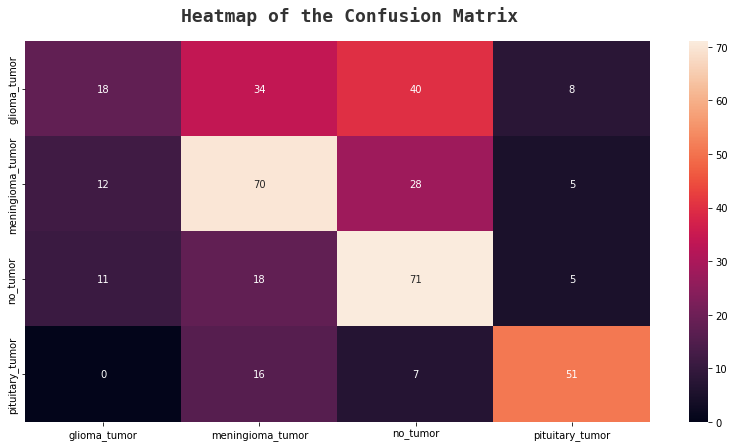

In [47]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

#Inception


In [50]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [51]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 0s 0us/step


In [52]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [53]:
x = Flatten()(inception.output)


In [56]:
prediction = Dense(4, activation='softmax')(x)

# create a model object
moodel = Model(inputs=inception.input, outputs=prediction)


In [57]:
moodel.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 111, 111, 32  96         ['conv2d_7[0][0]']               
 ormalization)                  )                                                           

In [58]:
from keras.utils.vis_utils import plot_model
plot_model(moodel, to_file='moodel.png', show_shapes=True, show_layer_names=True)

In [59]:
moodel.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [60]:
history = moodel.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 4.5976 - accuracy: 0.6540
Epoch 1: val_accuracy did not improve from 0.88031
73/73 [==============================] - 10s 77ms/step - loss: 4.5976 - accuracy: 0.6540 - val_loss: 1.8043 - val_accuracy: 0.7838 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 1.0516 - accuracy: 0.8580
Epoch 2: val_accuracy did not improve from 0.88031
73/73 [==============================] - 4s 53ms/step - loss: 1.0516 - accuracy: 0.8580 - val_loss: 3.2469 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 3/20
72/73 [============================>.] - ETA: 0s - loss: 0.3218 - accuracy: 0.9319
Epoch 3: val_accuracy did not improve from 0.88031
73/73 [==============================] - 4s 53ms/step - loss: 0.3197 - accuracy: 0.9320 - val_loss: 1.1708 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9733
Epoch 4: val_accuracy did not improve fro

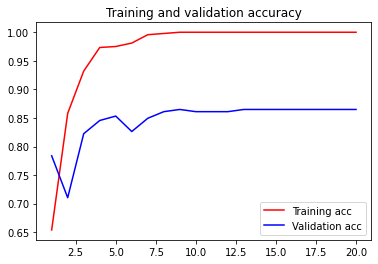

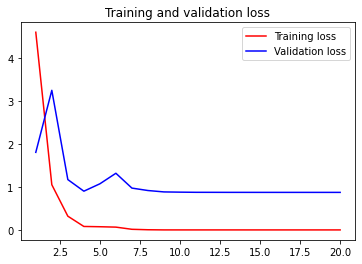

In [61]:
moodel.save('inception_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [62]:
pred = moodel.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [63]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 73.60%


In [64]:
moodel.evaluate(X_train, y_train)

81/81 [==============================] - 4s 50ms/step - loss: 0.0877 - accuracy: 0.9864


[0.08773063868284225, 0.9864498376846313]

In [65]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.77      0.23      0.35       100
           1       0.73      0.93      0.82       115
           2       0.68      0.99      0.81       105
           3       0.86      0.76      0.81        74

    accuracy                           0.74       394
   macro avg       0.76      0.73      0.70       394
weighted avg       0.75      0.74      0.70       394



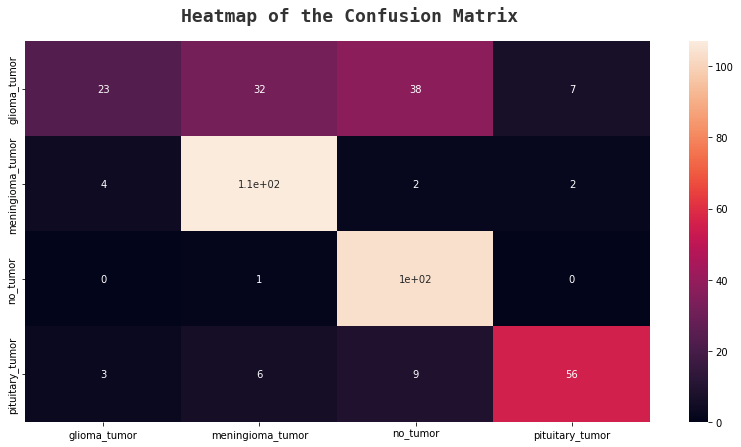

In [66]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**EfficientNetB0**

In [67]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


In [68]:
model_eff = effnet.output
model_eff = tf.keras.layers.GlobalAveragePooling2D()(model_eff)
model_eff = tf.keras.layers.Dropout(rate=0.5)(model_eff)
model_eff = tf.keras.layers.Dense(4,activation='softmax')(model_eff)
model_eff = tf.keras.models.Model(inputs=effnet.input, outputs = model_eff)
model_eff.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

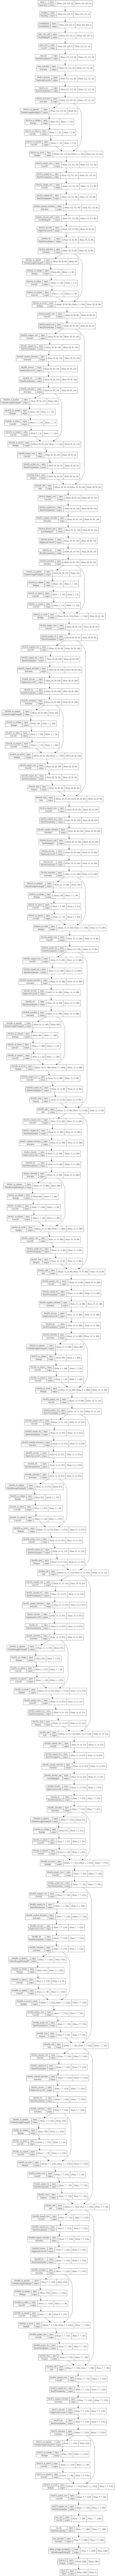

In [69]:
from keras.utils.vis_utils import plot_model
plot_model(model_eff, to_file='model_eff_plot.png', show_shapes=True, show_layer_names=True)

In [70]:
model_eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [71]:
history = model_eff.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8343
Epoch 1: val_accuracy did not improve from 0.88031
73/73 [==============================] - 27s 244ms/step - loss: 0.4384 - accuracy: 0.8343 - val_loss: 3.7749 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9428
Epoch 2: val_accuracy did not improve from 0.88031
73/73 [==============================] - 16s 217ms/step - loss: 0.1590 - accuracy: 0.9428 - val_loss: 4.4522 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9703
Epoch 3: val_accuracy did not improve from 0.88031

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 [==============================] - 16s 218ms/step - loss: 0.0811 - accuracy: 0.9703 - val_loss: 3.3631 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - E

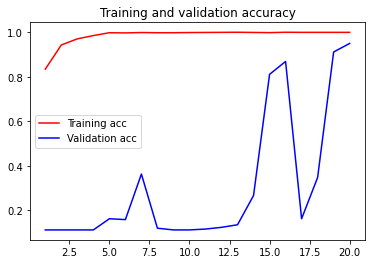

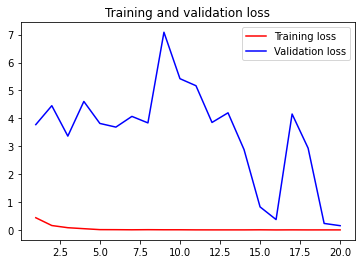

In [72]:
model_eff.save('model_eff.h5')

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Prediction**

In [73]:
pred = model_eff.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [74]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 74.62%


**Evaluation**

In [75]:
model_eff.evaluate(X_train, y_train)

81/81 [==============================] - 4s 44ms/step - loss: 0.0190 - accuracy: 0.9938


[0.01898878999054432, 0.9938056468963623]

In [76]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.31      0.47       100
           1       0.71      0.97      0.82       115
           2       0.68      0.99      0.81       105
           3       0.89      0.65      0.75        74

    accuracy                           0.75       394
   macro avg       0.81      0.73      0.71       394
weighted avg       0.80      0.75      0.71       394



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

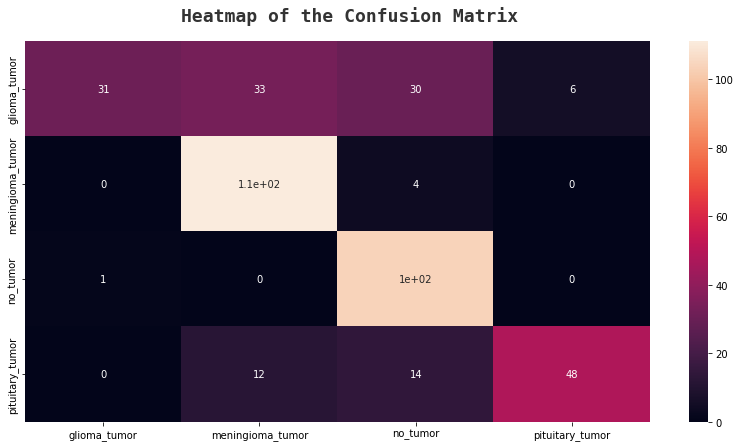

In [77]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

# Grad-CAM visualization

Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept.

**Grad-CAM of VGG16**

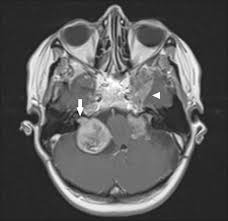

In [78]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="/content/drive/MyDrive/Testing/meningioma_tumor/image(100).jpg"

display(Image(img_path))

In [79]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n03868863', 'oxygen_mask', 10.318882)]


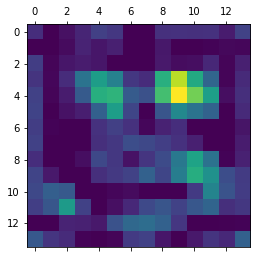

In [80]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

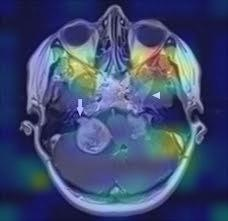

In [81]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

**Grad-CAM of EfficientNetB0**

In [82]:
model_builder = tf.keras.applications.efficientnet.EfficientNetB0
img_size = (224, 224)
preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "top_conv"

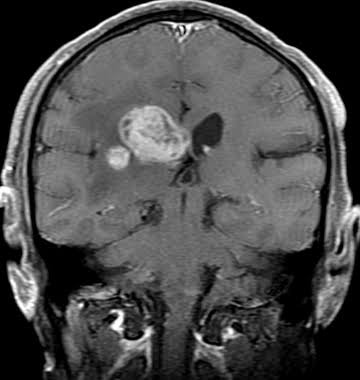

21848064/21834768 [==============================] - 0s 0us/step
Predicted: [('n03249569', 'drum', 6.1472025)]


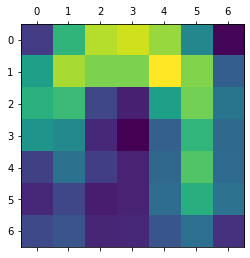

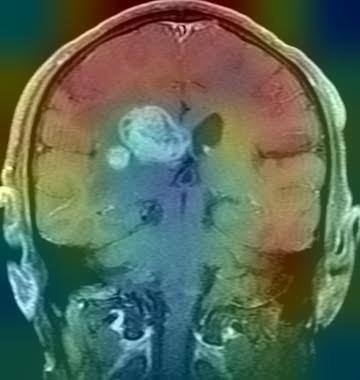

In [83]:
img_path ="/content/drive/MyDrive/Testing/glioma_tumor/image(13).jpg"

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

# Experimental results

In [84]:
# Function to convert output labels to its class of tumor.
def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

**Prediction using VGG16 model**

In [85]:
train_pred = model_vgg.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 86.02%


In [86]:
test_pred = model_vgg.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 53.30%


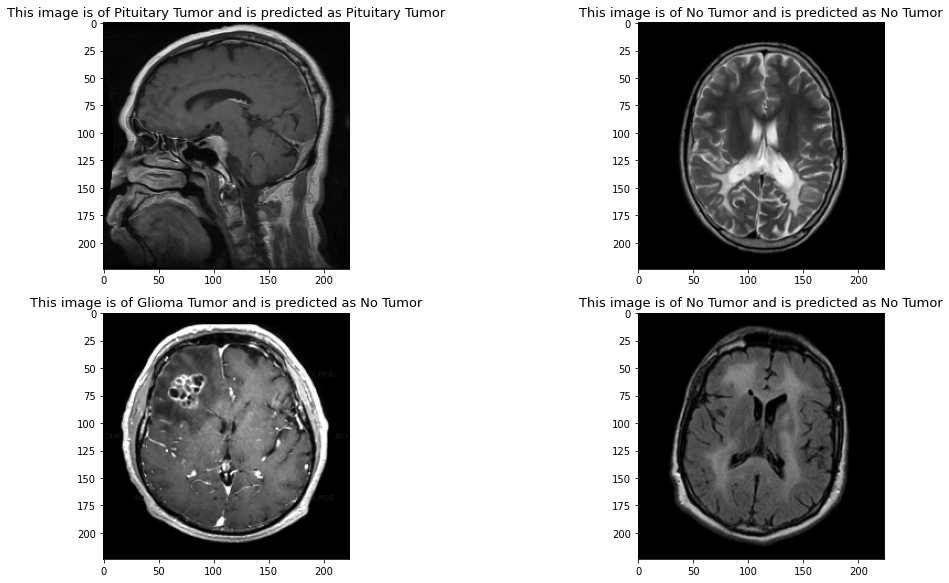

In [87]:
# Prediction using VGG16 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_vgg.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

#For Proposed Model 1

In [88]:
train_pred = model_cnn.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 83.62%


In [89]:
test_pred = model_cnn.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 63.96%


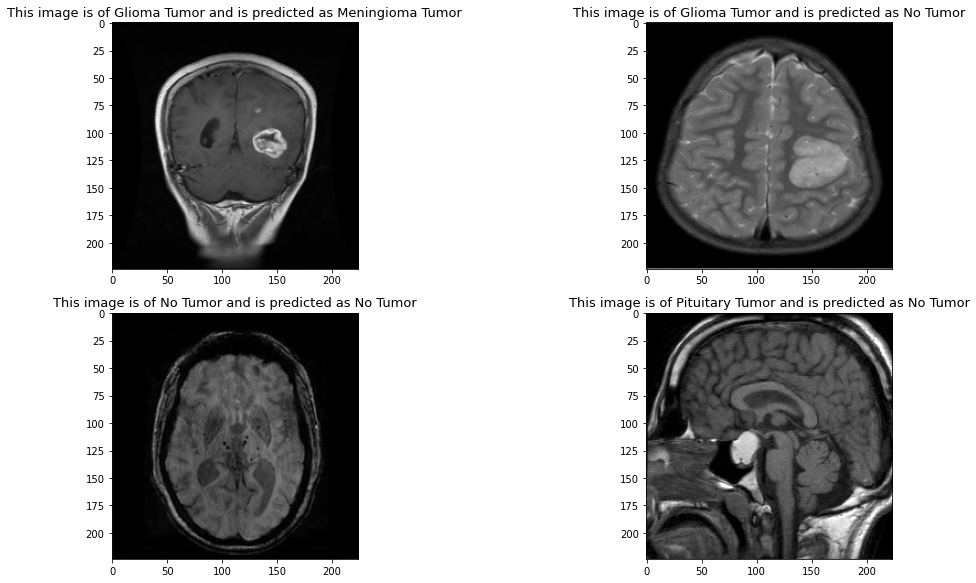

In [90]:
# Prediction using Proposed Model 1
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

#For Proposed Model 2

In [91]:
train_pred = model.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 0.00%


In [92]:
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 0.00%


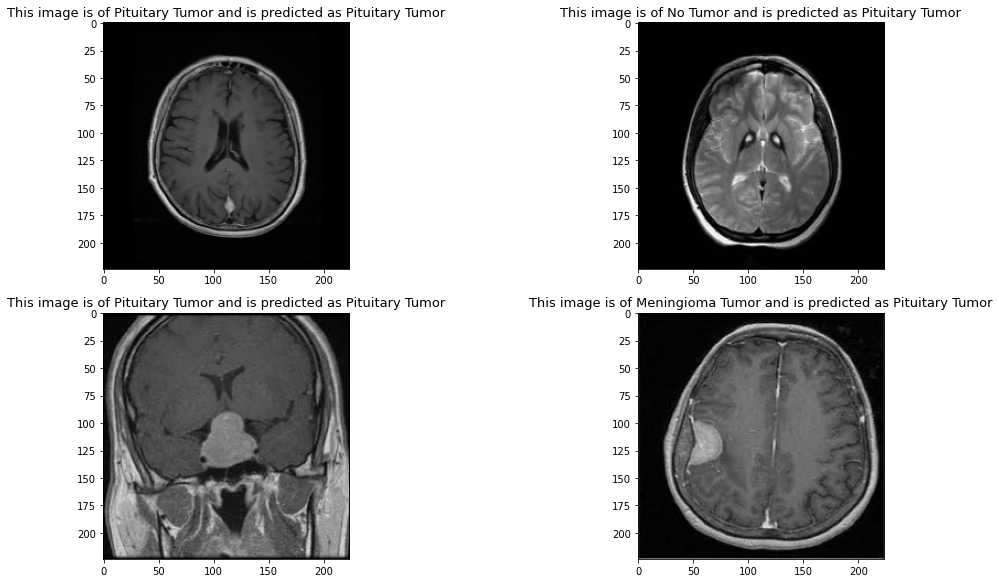

In [93]:
# Prediction using Proposed Model 1
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()

**Prediction using EfficientNetB0**

In [94]:
train_pred = model_eff.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 99.38%


In [95]:
test_pred = model_eff.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
Y_test_ = np.argmax(y_test, axis=1)
print("Accuracy on testing set: {:.2f}%".format(np.sum(test_pred==Y_test_)/len(Y_test_)*100))

Accuracy on testing set: 74.62%


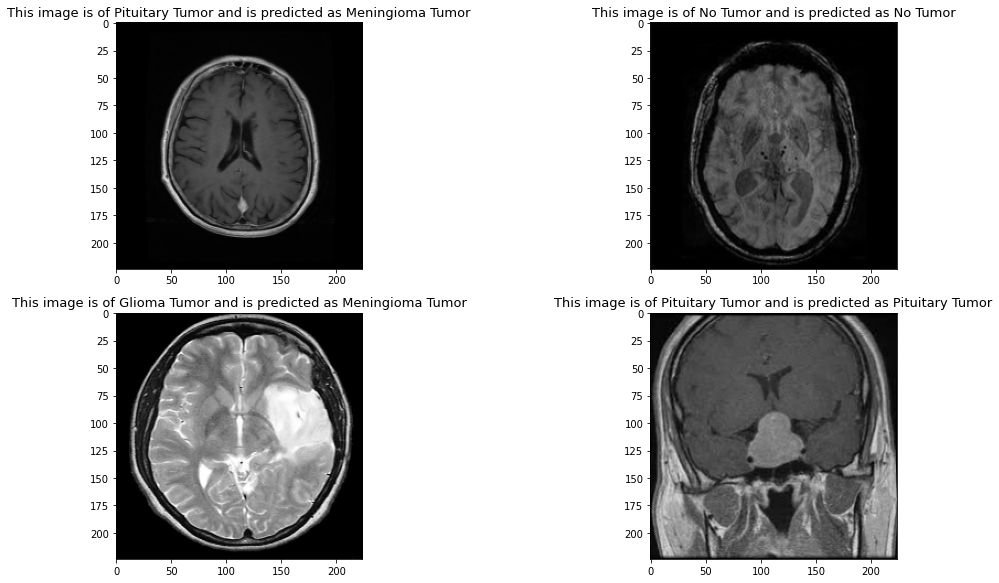

In [96]:
# Prediction using EfficientNetB0 model
plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(394)
    pred_class=inverse_classes(np.argmax(model_eff.predict(np.reshape(X_test[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(y_test_new[index]),pred_class),
              fontdict={'size':13})
    plt.imshow(X_test[index])
    plt.tight_layout()